In [1]:
import mlmarker
from mlmarker.model import MLMarker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

# 1. Comparison of the three datasets  
Provide MLMarker with the complete set of proteins detected in the three different sample preps and study differences in predictions.  

In general: 
All samples show a testis as a very likely tissue. This is often observed in samples containing a lot of secretion, etc.  
Evo96 and proteochipD0 showed more similar prediction patterns compared to the proteochipPFA.  ==> follow up analysis, which proteins are different?   
Evo96 and proteochipD0 both show Retina, a neuronal-like tissue with high probability which is promising!  

In [3]:
from collections import Counter
lengths = pd.read_csv('/home/compomics/git/MLMarker/uniprot_reviewed_lengths.tsv', sep='\t')    
protein_lists = []
for i in ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']:    
    df = pd.read_csv(i, sep='\t')
    proteins = np.array(df[["Protein.Ids"]].values.tolist()).flatten()
    # if it contains ';' split it and take both
    proteins = [x.split(';') for x in proteins]
    proteins = [item for sublist in proteins for item in sublist]
    frequency = Counter(proteins)
    df_frequency = pd.DataFrame.from_dict(frequency, orient='index', columns=['count']).reset_index()
    df_frequency = df_frequency.rename(columns={'index': 'proteins'})
    uniprot_df = df_frequency.merge(lengths, left_on='proteins', right_on='Entry')
    uniprot_df = uniprot_df[uniprot_df['Length'] != np.nan]
    uniprot_df['count'] = uniprot_df['count'].astype(float)
    uniprot_df['Length'] = uniprot_df['Length'].astype(float)
    uniprot_df['SAF'] = uniprot_df['count']/uniprot_df['Length']
    total_SAF = uniprot_df['SAF'].sum()
    uniprot_df['NSAF'] = uniprot_df['SAF']/total_SAF
    data = uniprot_df.pivot_table(columns='proteins', values='NSAF', aggfunc='sum')
    data = data.fillna(0)
    test = MLMarker(data.iloc[0:1,:], binary=False)
    prediction = test.explainability.adjusted_absent_shap_values_df(penalty_factor=1)
    prediction = prediction.sum(axis=1).sort_values(ascending=False).head(5)
    print(i, prediction)

/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2993, removed: 1332, remaining: 1391
evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv tissue
Pituitary gland    0.023739
Testis             0.007537
Lymph node         0.000000
Skeletal muscle    0.000000
Oviduct            0.000000
dtype: float64


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2456, removed: 1971, remaining: 1928
proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv tissue
NK-cells           0.012417
B-cells            0.006889
Kidney             0.006752
Pancreas           0.000655
Skeletal muscle    0.000000
dtype: float64


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3947, removed: 422, remaining: 437
proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv tissue
Prostate           0.071231
Salivary gland     0.040788
Ovary              0.030205
Lung               0.000000
Skeletal muscle    0.000000
dtype: float64


A standard PCA plot of proteins shows little difference between PFA and the others

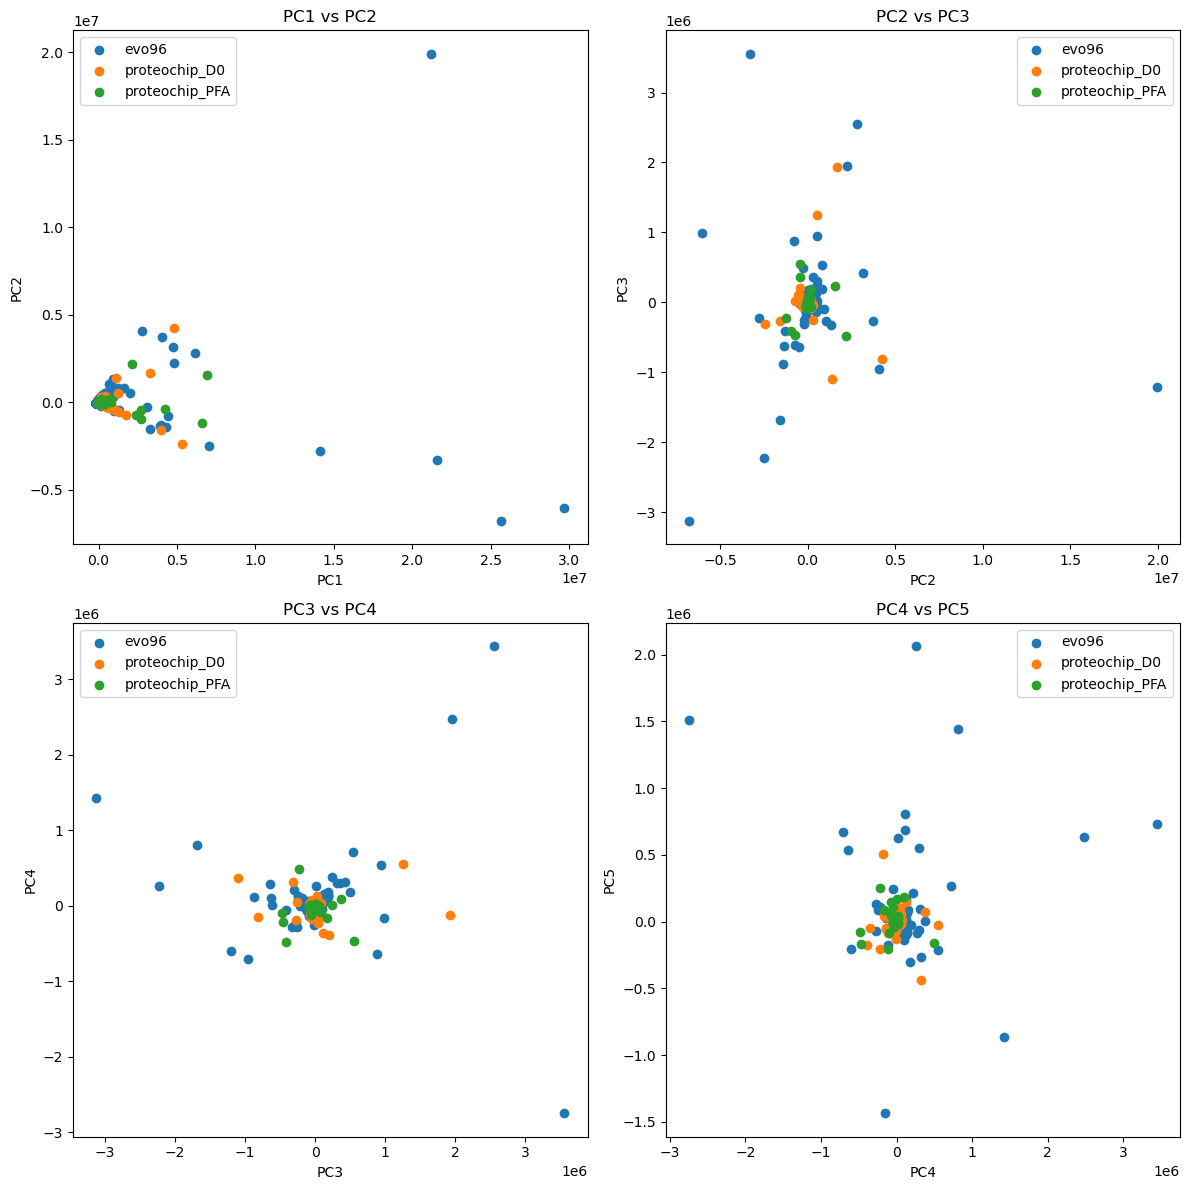

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

datasets = ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']
names = ['evo96', 'proteochip_D0', 'proteochip_PFA']

# Create a figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    # Read the data
    df = pd.read_csv(dataset, sep='\t')
    data = df.iloc[:, 5:].fillna(0).values
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=5)
    reduced_data = pca.fit_transform(data)
    
    # Plot the reduced data with color based on the dataset
    axs[0, 0].scatter(reduced_data[:, 0], reduced_data[:, 1], label=name)
    axs[0, 1].scatter(reduced_data[:, 1], reduced_data[:, 2], label=name)
    axs[1, 0].scatter(reduced_data[:, 2], reduced_data[:, 3], label=name)
    axs[1, 1].scatter(reduced_data[:, 3], reduced_data[:, 4], label=name)

# Add labels and titles for each subplot
axs[0, 0].set_title('PC1 vs PC2')
axs[0, 0].set_xlabel('PC1')
axs[0, 0].set_ylabel('PC2')
axs[0, 0].legend()

axs[0, 1].set_title('PC2 vs PC3')
axs[0, 1].set_xlabel('PC2')
axs[0, 1].set_ylabel('PC3')
axs[0, 1].legend()

axs[1, 0].set_title('PC3 vs PC4')
axs[1, 0].set_xlabel('PC3')
axs[1, 0].set_ylabel('PC4')
axs[1, 0].legend()

axs[1, 1].set_title('PC4 vs PC5')
axs[1, 1].set_xlabel('PC4')
axs[1, 1].set_ylabel('PC5')
axs[1, 1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


PCA on the predictions, not on the proteins shows a different pattern

In [28]:
first_elements = [t[0] for t in prediction]
print(first_elements)


['Salivary gland', 'Parotid gland', 'Ovary', 'Tonsil', 'Nasal polyps', 'Esophagus', 'Placenta', 'Monocytes', 'Urinary bladder', 'Appendix', 'Prostate', 'NK-cells', 'Skeletal muscle', 'Small intestine', 'Duodenum', 'Liver', 'Colon', 'Oviduct', 'Brain', 'Heart', 'Rectum', 'Thyroid', 'Testis', 'Adipose tissue', 'Adrenal gland', 'Pituitary gland', 'Stomach', 'Spleen', 'B-cells', 'Lymph node', 'Kidney', 'Smooth muscle', 'Lung', 'Endometrium', 'Pancreas']


In [42]:
import tqdm as tqdm
#minmax scale the data in column c
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

datasets = ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']
names = ['evo96', 'proteochip_D0', 'proteochip_PFA']
# Create a new dataframe to store the predictions
prediction_df = pd.DataFrame(columns=['dataset', 'sample', 'n_proteins', 'Salivary gland', 'Parotid gland', 'Ovary', 'Tonsil', 'Nasal polyps', 'Esophagus', 'Placenta', 'Monocytes', 'Urinary bladder', 'Appendix', 'Prostate', 'NK-cells', 'Skeletal muscle', 'Small intestine', 'Duodenum', 'Liver', 'Colon', 'Oviduct', 'Brain', 'Heart', 'Rectum', 'Thyroid', 'Testis', 'Adipose tissue', 'Adrenal gland', 'Pituitary gland', 'Stomach', 'Spleen', 'B-cells', 'Lymph node', 'Kidney', 'Smooth muscle', 'Lung', 'Endometrium', 'Pancreas'])

for name, dataset in zip(names, datasets):
    print(f"started on {name}")
    df = pd.read_csv(dataset, sep='\t')
    df.fillna(0, inplace=True)
    #do a column wise minmax normalization
    df['Protein.Ids'] = df['Protein.Ids'].astype(str).str.split(';').str[0]
    sub_df = df.set_index('Protein.Ids')
    sub_df.drop(columns=['Protein.Group', 'Protein.Names', 'Genes', 'First.Protein.Description'], inplace=True)
    sub_df_minmax = scaler.fit_transform(sub_df)
    sub_df = pd.DataFrame(sub_df_minmax, columns=sub_df.columns, index=sub_df.index)
    sub_df.fillna(0, inplace=True)
    sub_df = sub_df.astype(float)
    sub_df = sub_df.T

    # Iterate over each row in sub_df
    for i in tqdm.tqdm(range(sub_df.shape[0])):
        test = MLMarker(sub_df.iloc[i:i+1,:], binary=False)
        prediction = test.explainability.adjusted_absent_shap_values_df(n_preds=100, penalty_factor=1).sum(axis=1).sort_values(ascending=False)
        prediction = list(prediction.items())
        new_name = str(name) + "_" + str(sub_df.index[i])
        num_nonzero_columns = (sub_df.iloc[i:i+1,:] != 0).sum(axis=1).values[0]
        num_nonzero_columns
        # Create a new row in prediction_df
        prediction_df = pd.concat([prediction_df, pd.DataFrame({'dataset': [name], 'sample': [new_name], 'n_proteins': [num_nonzero_columns]})], ignore_index=True)
        
        # Add the predictions to the new row
        for tissue, prob in prediction:
            prediction_df.loc[prediction_df.index[-1], tissue] = prob


started on evo96


  0%|          | 0/35 [00:00<?, ?it/s]

/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


  3%|▎         | 1/35 [00:01<01:07,  1.99s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


  6%|▌         | 2/35 [00:03<01:06,  2.00s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


  9%|▊         | 3/35 [00:06<01:04,  2.02s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 11%|█▏        | 4/35 [00:08<01:03,  2.03s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 14%|█▍        | 5/35 [00:10<01:00,  2.02s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 17%|█▋        | 6/35 [00:12<00:58,  2.03s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 20%|██        | 7/35 [00:14<00:57,  2.04s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 23%|██▎       | 8/35 [00:16<00:55,  2.05s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 26%|██▌       | 9/35 [00:18<00:53,  2.06s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 29%|██▊       | 10/35 [00:20<00:50,  2.03s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 31%|███▏      | 11/35 [00:22<00:48,  2.03s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 34%|███▍      | 12/35 [00:24<00:48,  2.11s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 37%|███▋      | 13/35 [00:26<00:46,  2.10s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 40%|████      | 14/35 [00:28<00:43,  2.08s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 43%|████▎     | 15/35 [00:30<00:41,  2.06s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 46%|████▌     | 16/35 [00:32<00:39,  2.06s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 49%|████▊     | 17/35 [00:34<00:37,  2.06s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 51%|█████▏    | 18/35 [00:36<00:34,  2.05s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 54%|█████▍    | 19/35 [00:38<00:32,  2.06s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 57%|█████▋    | 20/35 [00:40<00:30,  2.04s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 60%|██████    | 21/35 [00:43<00:28,  2.05s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 63%|██████▎   | 22/35 [00:45<00:26,  2.06s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 66%|██████▌   | 23/35 [00:47<00:24,  2.07s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 69%|██████▊   | 24/35 [00:49<00:22,  2.04s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 71%|███████▏  | 25/35 [00:51<00:20,  2.04s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 74%|███████▍  | 26/35 [00:53<00:18,  2.02s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 77%|███████▋  | 27/35 [00:55<00:16,  2.04s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 80%|████████  | 28/35 [00:57<00:14,  2.03s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 83%|████████▎ | 29/35 [00:59<00:12,  2.02s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 86%|████████▌ | 30/35 [01:01<00:10,  2.02s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 89%|████████▊ | 31/35 [01:03<00:08,  2.03s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 91%|█████████▏| 32/35 [01:05<00:06,  2.04s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 94%|█████████▍| 33/35 [01:07<00:04,  2.03s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


 97%|█████████▋| 34/35 [01:09<00:02,  2.04s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3085, removed: 1089, remaining: 1299


100%|██████████| 35/35 [01:11<00:00,  2.04s/it]


started on proteochip_D0


  0%|          | 0/44 [00:00<?, ?it/s]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


  2%|▏         | 1/44 [00:02<01:49,  2.55s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


  5%|▍         | 2/44 [00:05<01:47,  2.56s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


  7%|▋         | 3/44 [00:07<01:44,  2.55s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


  9%|▉         | 4/44 [00:10<01:41,  2.53s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 11%|█▏        | 5/44 [00:12<01:38,  2.54s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 14%|█▎        | 6/44 [00:15<01:37,  2.57s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 16%|█▌        | 7/44 [00:18<01:37,  2.65s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 18%|█▊        | 8/44 [00:20<01:34,  2.63s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 20%|██        | 9/44 [00:23<01:31,  2.62s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 23%|██▎       | 10/44 [00:25<01:28,  2.61s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 25%|██▌       | 11/44 [00:28<01:25,  2.60s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 27%|██▋       | 12/44 [00:31<01:22,  2.58s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 30%|██▉       | 13/44 [00:33<01:20,  2.58s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 32%|███▏      | 14/44 [00:36<01:17,  2.57s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 34%|███▍      | 15/44 [00:38<01:14,  2.56s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 36%|███▋      | 16/44 [00:41<01:11,  2.56s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 39%|███▊      | 17/44 [00:43<01:08,  2.55s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 41%|████      | 18/44 [00:46<01:06,  2.56s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 43%|████▎     | 19/44 [00:48<01:04,  2.58s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 45%|████▌     | 20/44 [00:51<01:02,  2.59s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 48%|████▊     | 21/44 [00:54<00:59,  2.59s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 50%|█████     | 22/44 [00:56<00:57,  2.59s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 52%|█████▏    | 23/44 [00:59<00:54,  2.59s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 55%|█████▍    | 24/44 [01:01<00:51,  2.58s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 57%|█████▋    | 25/44 [01:04<00:48,  2.56s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 59%|█████▉    | 26/44 [01:07<00:46,  2.58s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 61%|██████▏   | 27/44 [01:09<00:43,  2.56s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 64%|██████▎   | 28/44 [01:12<00:40,  2.56s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 66%|██████▌   | 29/44 [01:14<00:38,  2.55s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 68%|██████▊   | 30/44 [01:17<00:35,  2.56s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 70%|███████   | 31/44 [01:19<00:33,  2.56s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 73%|███████▎  | 32/44 [01:22<00:30,  2.56s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 75%|███████▌  | 33/44 [01:25<00:29,  2.65s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 77%|███████▋  | 34/44 [01:27<00:26,  2.60s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 80%|███████▉  | 35/44 [01:30<00:23,  2.57s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 82%|████████▏ | 36/44 [01:32<00:20,  2.57s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 84%|████████▍ | 37/44 [01:35<00:17,  2.57s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 86%|████████▋ | 38/44 [01:37<00:15,  2.58s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 89%|████████▊ | 39/44 [01:40<00:12,  2.59s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 91%|█████████ | 40/44 [01:43<00:10,  2.58s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 93%|█████████▎| 41/44 [01:45<00:07,  2.57s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 95%|█████████▌| 42/44 [01:48<00:05,  2.54s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


 98%|█████████▊| 43/44 [01:50<00:02,  2.55s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 2535, removed: 1750, remaining: 1849


100%|██████████| 44/44 [01:53<00:00,  2.58s/it]


started on proteochip_PFA


  0%|          | 0/41 [00:00<?, ?it/s]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


  2%|▏         | 1/41 [00:01<00:55,  1.39s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


  5%|▍         | 2/41 [00:02<00:55,  1.42s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


  7%|▋         | 3/41 [00:04<00:53,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 10%|▉         | 4/41 [00:05<00:52,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 12%|█▏        | 5/41 [00:07<00:50,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 15%|█▍        | 6/41 [00:08<00:49,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 17%|█▋        | 7/41 [00:09<00:47,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 20%|█▉        | 8/41 [00:11<00:46,  1.42s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 22%|██▏       | 9/41 [00:12<00:45,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 24%|██▍       | 10/41 [00:14<00:43,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 27%|██▋       | 11/41 [00:15<00:41,  1.40s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 29%|██▉       | 12/41 [00:16<00:40,  1.40s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 32%|███▏      | 13/41 [00:18<00:42,  1.50s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 34%|███▍      | 14/41 [00:20<00:39,  1.48s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 37%|███▋      | 15/41 [00:21<00:37,  1.46s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 39%|███▉      | 16/41 [00:22<00:36,  1.45s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 41%|████▏     | 17/41 [00:24<00:34,  1.44s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 44%|████▍     | 18/41 [00:25<00:32,  1.43s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 46%|████▋     | 19/41 [00:27<00:31,  1.43s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 49%|████▉     | 20/41 [00:28<00:29,  1.43s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 51%|█████     | 21/41 [00:29<00:28,  1.42s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 54%|█████▎    | 22/41 [00:31<00:26,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 56%|█████▌    | 23/41 [00:32<00:25,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 59%|█████▊    | 24/41 [00:34<00:24,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 61%|██████    | 25/41 [00:35<00:22,  1.40s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 63%|██████▎   | 26/41 [00:36<00:21,  1.40s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 66%|██████▌   | 27/41 [00:38<00:19,  1.40s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 68%|██████▊   | 28/41 [00:39<00:18,  1.40s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 71%|███████   | 29/41 [00:41<00:16,  1.39s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 73%|███████▎  | 30/41 [00:42<00:15,  1.40s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 76%|███████▌  | 31/41 [00:43<00:14,  1.40s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 78%|███████▊  | 32/41 [00:45<00:12,  1.42s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 80%|████████  | 33/41 [00:46<00:11,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 83%|████████▎ | 34/41 [00:48<00:09,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 85%|████████▌ | 35/41 [00:49<00:08,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 88%|████████▊ | 36/41 [00:51<00:07,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 90%|█████████ | 37/41 [00:52<00:05,  1.41s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 93%|█████████▎| 38/41 [00:53<00:04,  1.42s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 95%|█████████▌| 39/41 [00:55<00:02,  1.40s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


 98%|█████████▊| 40/41 [00:56<00:01,  1.49s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4384 features loaded
Features added: 3997, removed: 317, remaining: 387


100%|██████████| 41/41 [00:58<00:00,  1.42s/it]


In [43]:
prediction_df.fillna(0, inplace=True)

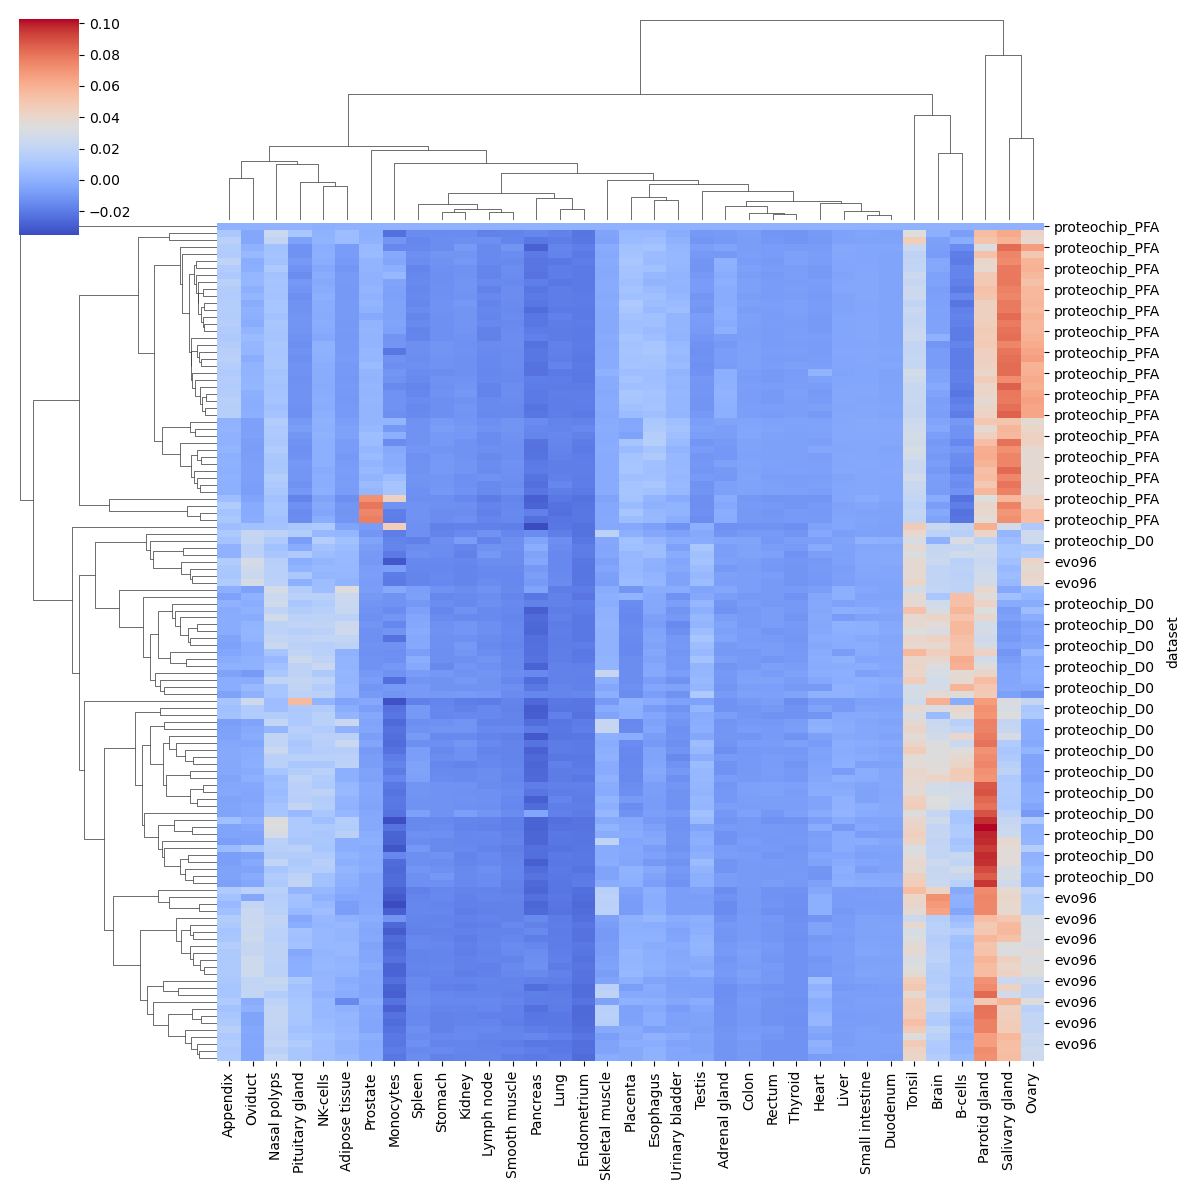

In [44]:
sns.clustermap(prediction_df.set_index('dataset').iloc[:, 2:].astype(float), cmap='coolwarm', figsize=(12, 12))


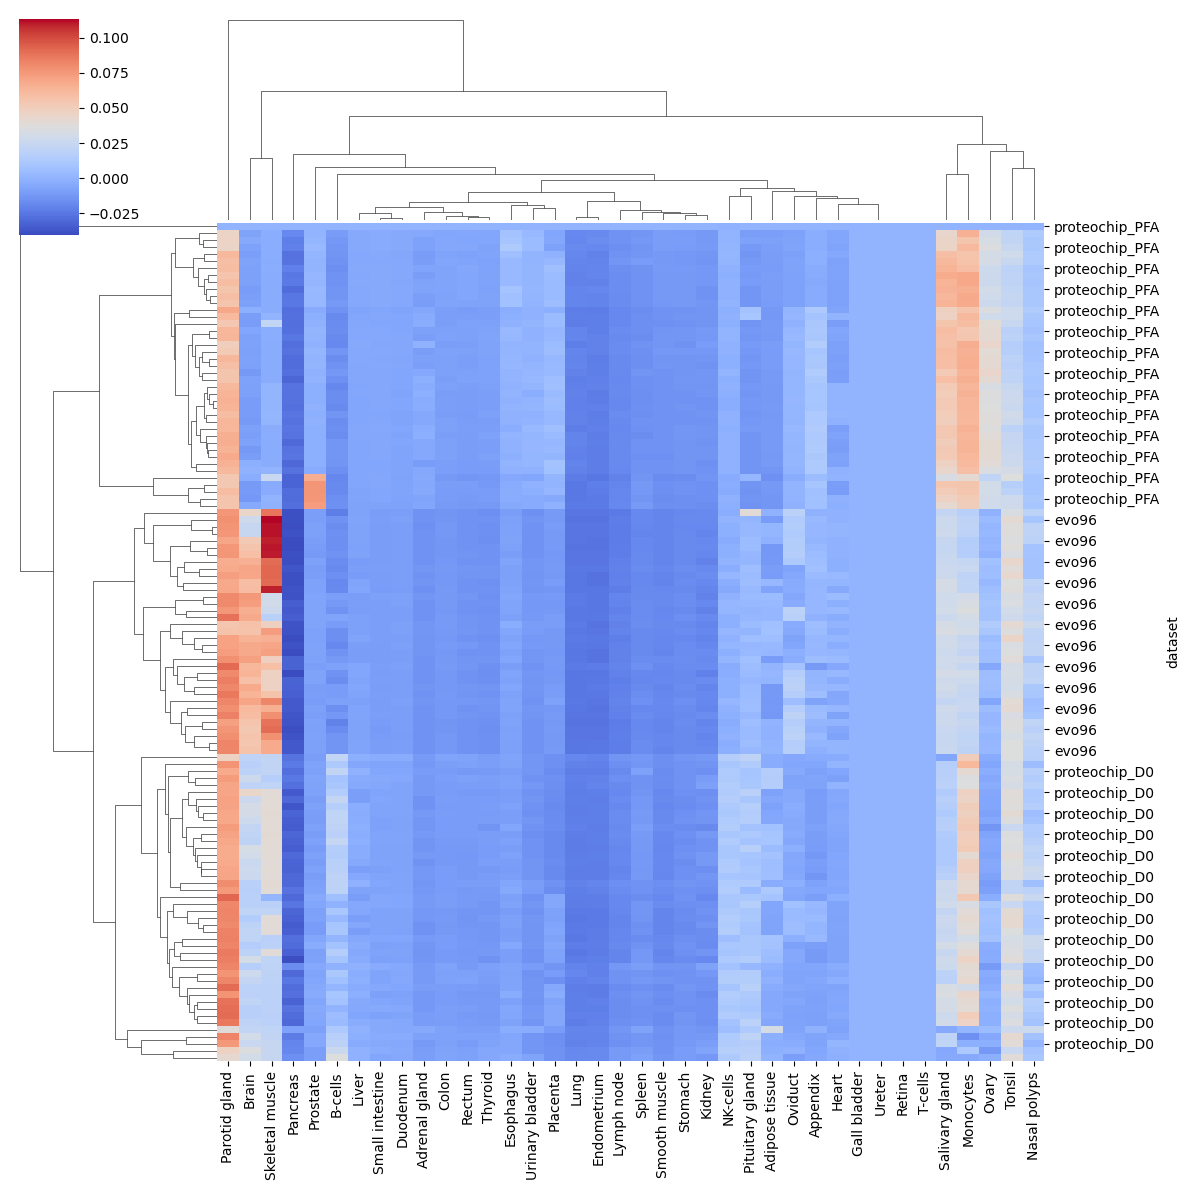

In [ ]:
sns.clustermap(prediction_df.iloc[:, 3:], cmap='coolwarm', figsize=(12, 12))

/tmp/ipykernel_82925/1161966105.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  reduced_data = pca.fit_transform(prediction_df.fillna(0).drop(columns=['sample', 'dataset', 'n_proteins']))


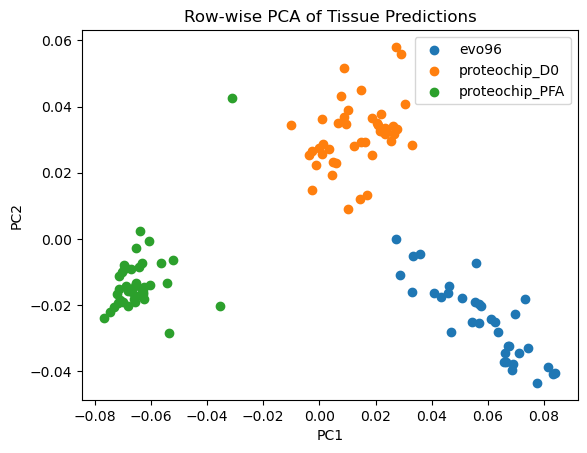

In [11]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(prediction_df.fillna(0).drop(columns=['sample', 'dataset', 'n_proteins']))

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    # Get the indices of samples from the current dataset
    indices = prediction_df[prediction_df['dataset'] == name].index
    
    # Plot the reduced data with color based on the dataset
    ax.scatter(reduced_data[indices, 0], reduced_data[indices, 1], label=name)

# Add labels and title
ax.set_title('Row-wise PCA of Tissue Predictions')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

# Show the plot
plt.show()


Is this because of a difference in the number of proteins (and consequentially missing values in the predictor)

/tmp/ipykernel_82925/3170636087.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  reduced_data = pca.fit_transform(prediction_df.fillna(0).drop(columns=['sample', 'dataset', 'Brain']))


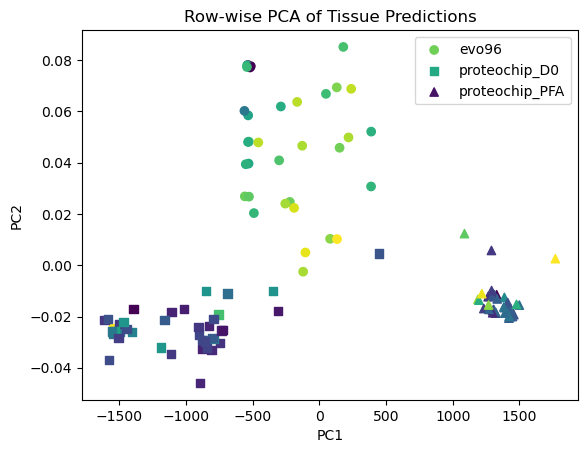

In [13]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(prediction_df.fillna(0).drop(columns=['sample', 'dataset', 'Brain']))

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    # Get the indices of samples from the current dataset
    indices = prediction_df[prediction_df['dataset'] == name].index
    
    # Get the number of proteins for each sample
    n_proteins = prediction_df.loc[indices, 'Brain']
    
    # Set the marker type based on the dataset
    marker = 'o' if name == 'evo96' else 's' if name == 'proteochip_D0' else '^'
    
    # Plot the reduced data with color and marker type
    ax.scatter(reduced_data[indices, 0], reduced_data[indices, 1], c=n_proteins, marker=marker, label=name)

# Add labels and title
ax.set_title('Row-wise PCA of Tissue Predictions')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

# Show the plot
plt.show()


So, the protein PCA does not show tremendous differences but the predictions do!  
This can be caused by the fact that MLMarker looks at less proteins than are present within the sample and maybe those are just different? Let's remake the protein PCA with only those proteins

In [14]:
features_path = "/home/compomics/git/MLMarker/models/features_TP_full_92%_10exp_2024.txt"
with open(features_path, 'r') as features_file:
    features = features_file.read().split(',\n')


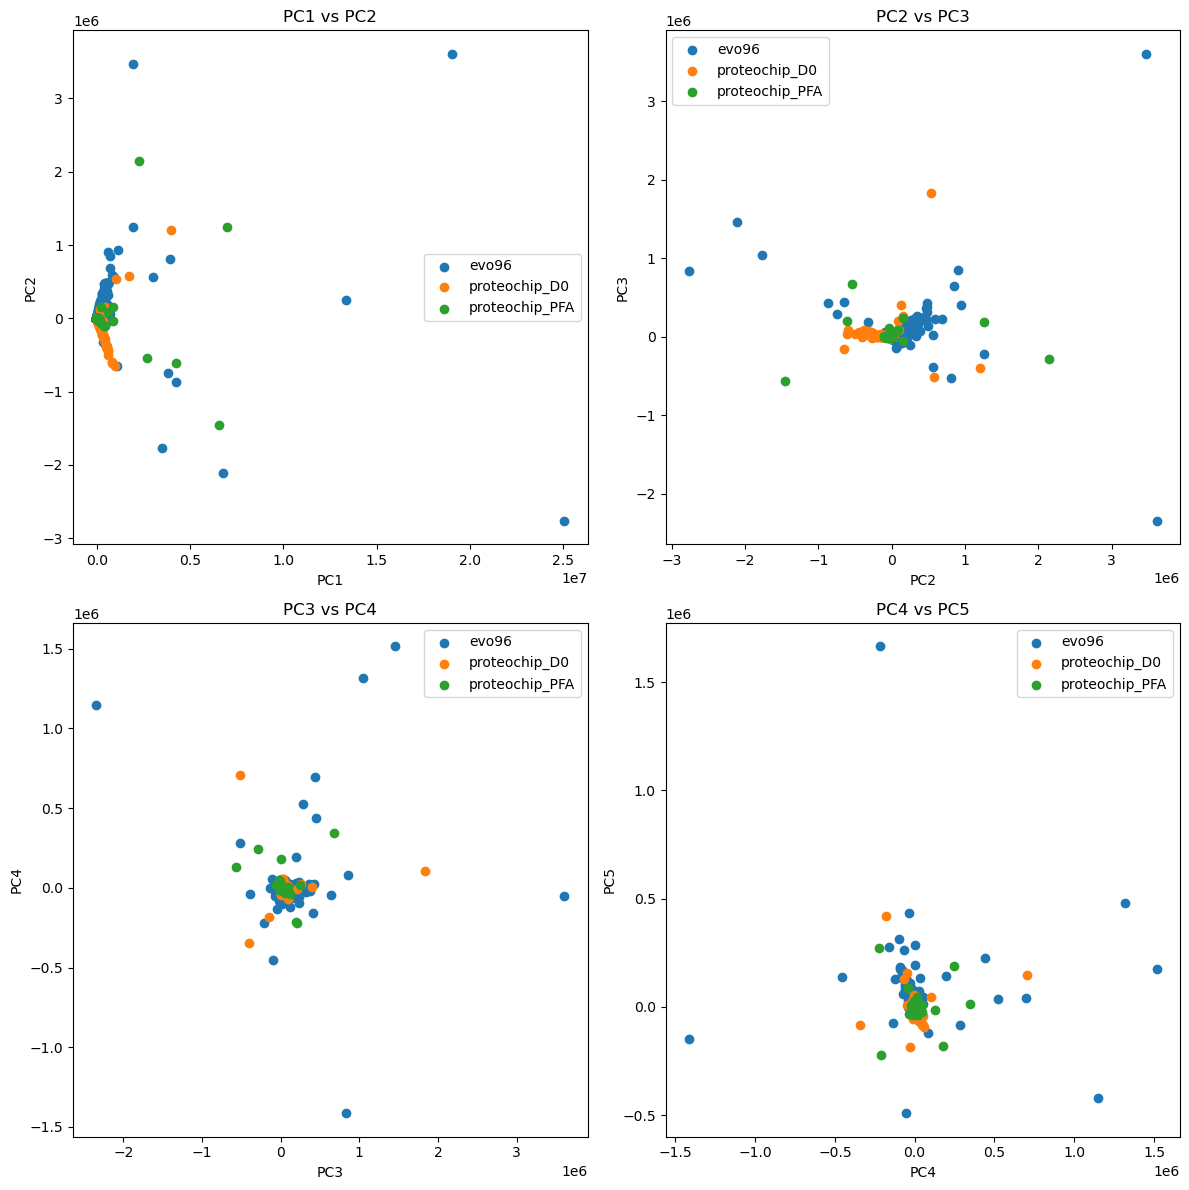

In [20]:
#PCA with MLMarker features

datasets = ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']
names = ['evo96', 'proteochip_D0', 'proteochip_PFA']

# Create a figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    # Read the data
    df = pd.read_csv(dataset, sep='\t')
    df['Protein.Ids'] = df['Protein.Ids'].astype(str).str.split(';').str[0]
    df = df[df['Protein.Ids'].isin(features)] #only use the MLMarker proteins
    #add the missing proteins with 0 values
    missing_proteins = list(set(features) - set(df['Protein.Ids']))
    #add the missing proteins to the protein.ids column with zero values across the whole row
    df = pd.concat([df, pd.DataFrame(np.zeros((len(missing_proteins), df.shape[1])), columns=df.columns.tolist())])
    df = df.set_index('Protein.Ids')
    data = df.iloc[:, 5:].fillna(0).values
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=5)
    reduced_data = pca.fit_transform(data)
    
    # Plot the reduced data with color based on the dataset
    axs[0, 0].scatter(reduced_data[:, 0], reduced_data[:, 1], label=name)
    axs[0, 1].scatter(reduced_data[:, 1], reduced_data[:, 2], label=name)
    axs[1, 0].scatter(reduced_data[:, 2], reduced_data[:, 3], label=name)
    axs[1, 1].scatter(reduced_data[:, 3], reduced_data[:, 4], label=name)

# Add labels and titles for each subplot
axs[0, 0].set_title('PC1 vs PC2')
axs[0, 0].set_xlabel('PC1')
axs[0, 0].set_ylabel('PC2')
axs[0, 0].legend()

axs[0, 1].set_title('PC2 vs PC3')
axs[0, 1].set_xlabel('PC2')
axs[0, 1].set_ylabel('PC3')
axs[0, 1].legend()

axs[1, 0].set_title('PC3 vs PC4')
axs[1, 0].set_xlabel('PC3')
axs[1, 0].set_ylabel('PC4')
axs[1, 0].legend()

axs[1, 1].set_title('PC4 vs PC5')
axs[1, 1].set_xlabel('PC4')
axs[1, 1].set_ylabel('PC5')
axs[1, 1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


There is no such difference from PFA on a protein level even with only the trained proteins (from which the missing ones are added as zero values).  
The most logical solution for this is that the lower amount of proteins within PFA impacts the prediction a lot which is not visible within the proteinlevel PCA.

This means that the MLMarker can detect levels at the proteome level which are not visible from the individual proteins. MLMarker is binary so it's also not a matter of higher or lower expressed proteins!  


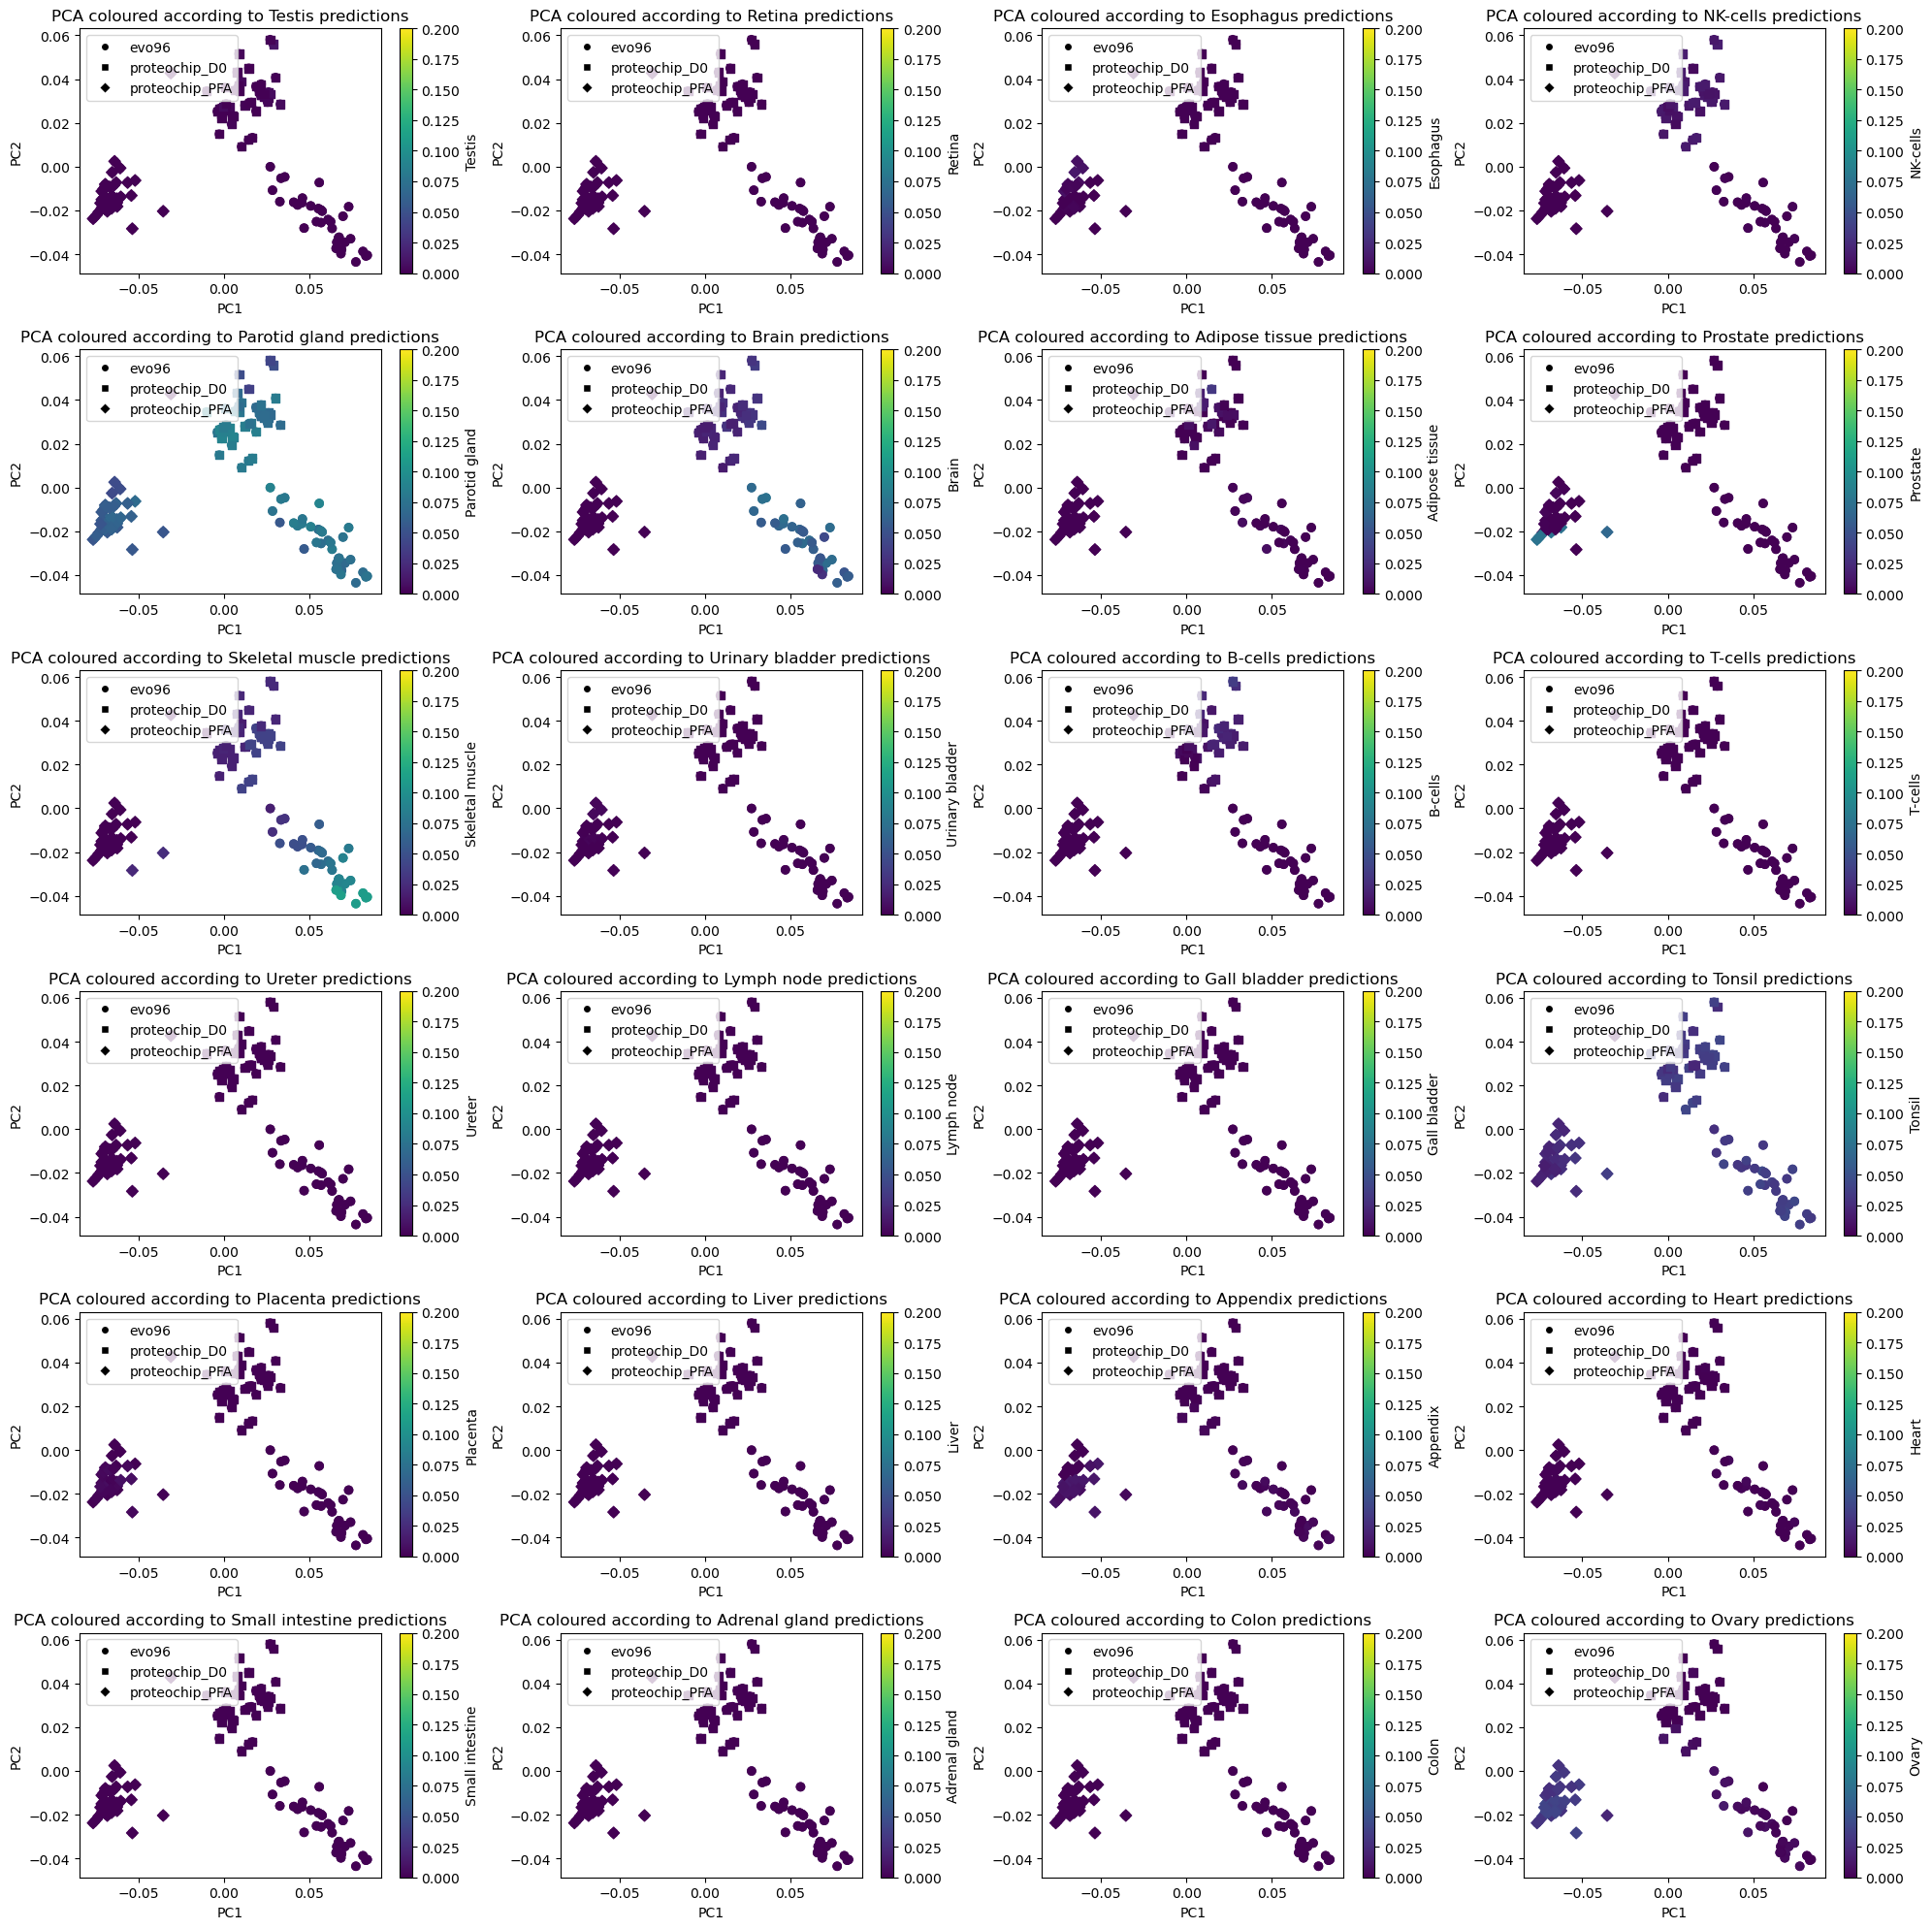

In [25]:
fig, axs = plt.subplots(6, 4, figsize=(20, 20))  # Create a figure with 6 rows and 4 columns
prediction_df.reset_index(inplace=True)
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(prediction_df.drop(columns=['sample', 'dataset', 'n_proteins']))
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_pca[['Testis', 'Retina', 'Parotid gland', 'Brain',
       'Adipose tissue', 'Prostate', 'NK-cells', 'Skeletal muscle',
       'Urinary bladder', 'B-cells', 'Esophagus', 'T-cells', 'Ureter',
       'Lymph node', 'Gall bladder', 'Tonsil', 'Placenta', 'Liver', 'Appendix',
       'Heart', 'Small intestine', 'Adrenal gland', 'Colon', 'Ovary',
       'Salivary gland', 'Monocytes', 'Nasal polyps', 'Pituitary gland',
       'Oviduct', 'Duodenum', 'Rectum', 'Thyroid', 'Spleen', 'Stomach',
       'Smooth muscle', 'Kidney', 'Lung', 'Endometrium', 'Pancreas']] = prediction_df.iloc[:, 3:]
df_pca[['sample', 'dataset']] = prediction_df[['sample', 'dataset']]

#add a column that states the number of proteins in the sample


tissues = ['Testis', 'Retina', 'Esophagus', 'NK-cells', 'Parotid gland', 'Brain', 'Adipose tissue', 'Prostate', 'Skeletal muscle', 'Urinary bladder', 'B-cells', 'T-cells', 'Ureter', 'Lymph node', 'Gall bladder', 'Tonsil', 'Placenta', 'Liver', 'Appendix', 'Heart', 'Small intestine', 'Adrenal gland', 'Colon', 'Ovary']

for i, t in enumerate(tissues):
    row = i // 4  # Calculate the row index
    col = i % 4  # Calculate the column index
    
    ax = axs[row, col]  # Select the current subplot
    
    scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca[t], cmap='viridis', vmin=0, vmax=0.2)
    
    # Change marker type according to the dataset column
    markers = ['o', 's', 'D']  # Define marker types for each dataset
    
    for j, dataset in enumerate(df_pca['dataset'].unique()):
        indices = df_pca['dataset'] == dataset
        ax.scatter(df_pca.loc[indices, 'PC1'], df_pca.loc[indices, 'PC2'], c=df_pca.loc[indices, t], cmap='viridis', marker=markers[j], label=dataset, vmin=0, vmax=0.2)
    
    # Add legend for marker type
    legend_markers = [plt.Line2D([0], [0], marker=marker, color='w', label=dataset, markerfacecolor='k') for marker, dataset in zip(markers, df_pca['dataset'].unique())]
    ax.legend(handles=legend_markers)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(t)
    
    # Add labels and title
    ax.set_title(f'PCA coloured according to {t} predictions')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



# 2. Continuing with the proteochipD0 data, how different are individual cells?  

This dataset showed the most variability within this group. Are these single cells very different from each other?


In [27]:
#all proteins combined
df = pd.read_csv("/home/compomics/git/MLMarker/Projects/organoids_pauline/evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv", sep='\t')
proteins = np.array(df[["Protein.Ids"]].values.tolist()).flatten()
# if it contains ';' split it and take both
proteins = [x.split(';') for x in proteins]
proteins = [item for sublist in proteins for item in sublist]
proteins = list(set(proteins))

#make a dataframe with the proteins as column names, only one row and all values 1
data = np.ones((1, len(proteins)))
predict_df = pd.DataFrame(data, columns=proteins)

test = MLMarker(predict_df.iloc[0:1,:], binary = False)
prediction = MLMarker.adjusted_shap_values_df(test, n_preds=100, penalty_factor=0.5).sum(axis=1).sort_values(ascending=False)
prediction = list(prediction.items())
print(prediction)

/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[('Skeletal muscle', 0.09531802436580213), ('Parotid gland', 0.06333352397445675), ('Brain', 0.050226669710908625), ('Monocytes', 0.04907725842536715), ('Pituitary gland', 0.04512747676789508), ('Tonsil', 0.03443351904561601), ('Salivary gland', 0.018751573564554504), ('Heart', 0.008602340937223604), ('B-cells', 0.006084048578668049), ('Nasal polyps', 0.005874326625534534), ('Oviduct', 0.00522535900054253), ('Ovary', 0.001003335343982599), ('Testis', -0.0005769201231923857), ('NK-cells', -0.0035714245503904673), ('Adipose tissue', -0.0058469037727852885), ('Appendix', -0.007877484902447513), ('Pancreas', -0.00863201248728545), ('Esophagus', -0.01182015031515451), ('Prostate', -0.014097464289265185), ('Kidney', -0.015890557901604225), ('Liver', -0.016148216407888966), ('Placenta', -0.01696437545259168), ('Small intestine', -0.018125526164598747), ('Urinary bladder', -0.018514582310178197), ('Duodenum', -0.018974357828219223), ('Colon', -0.019691665294021315), ('Rectum', -0.0206644001461

In [30]:
import tqdm as tqdm
#individual samples
df = pd.read_csv("evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv", sep='\t')
df['Protein.Ids'] = df['Protein.Ids'].astype(str).str.split(';').str[0]
sub_df = df.set_index('Protein.Ids')
sub_df.drop(columns=['Protein.Group', 'Protein.Names', 'Genes', 'First.Protein.Description'], inplace=True)
sub_df = sub_df.T
sub_df.fillna(0, inplace=True)
sub_df = sub_df.astype(float)

# Create a new dataframe to store the predictions
prediction_df2 = pd.DataFrame(columns=['sample','Testis',  'Retina',  'Esophagus','Parotid gland',  'Brain',  'Adipose tissue',  'Skeletal muscle', 
'Prostate',  'NK-cells',  'B-cells', 'Urinary bladder',   'Lymph node',    'T-cells',  'Ureter',  
 'Gall bladder',  'Tonsil',  'Placenta',  'Liver',  'Appendix',  'Heart',  'Small intestine',  'Adrenal gland', 
 'Colon',  'Ovary'])

# Predict and add the predictions to the dataframe
for i in tqdm.tqdm(range(sub_df.shape[0])):
    
    test = MLMarker(sub_df.iloc[i:i+1,:], binary=False)
    prediction = MLMarker.adjusted_shap_values_df(test, n_preds=100).sum(axis=1).sort_values(ascending=False)
    prediction = list(prediction.items())
    prediction_df2.loc[i, 'sample'] = sub_df.index[i]
    for tissue, prob in prediction:
        prediction_df2.loc[i, tissue] = prob

#drop columns with only nan
prediction_df2.dropna(axis=1, how='all', inplace=True)


  0%|          | 0/35 [00:00<?, ?it/s]

/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


  3%|▎         | 1/35 [00:02<01:08,  2.02s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


  6%|▌         | 2/35 [00:04<01:07,  2.04s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


  9%|▊         | 3/35 [00:06<01:05,  2.05s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 11%|█▏        | 4/35 [00:08<01:03,  2.06s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 14%|█▍        | 5/35 [00:10<01:01,  2.04s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 17%|█▋        | 6/35 [00:12<01:00,  2.07s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 20%|██        | 7/35 [00:14<01:01,  2.19s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 23%|██▎       | 8/35 [00:16<00:57,  2.13s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 26%|██▌       | 9/35 [00:18<00:54,  2.10s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 29%|██▊       | 10/35 [00:20<00:51,  2.07s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 31%|███▏      | 11/35 [00:22<00:49,  2.07s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 34%|███▍      | 12/35 [00:24<00:47,  2.08s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 37%|███▋      | 13/35 [00:27<00:45,  2.06s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 40%|████      | 14/35 [00:29<00:43,  2.06s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 43%|████▎     | 15/35 [00:31<00:41,  2.06s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 46%|████▌     | 16/35 [00:33<00:39,  2.08s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 49%|████▊     | 17/35 [00:35<00:37,  2.06s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 51%|█████▏    | 18/35 [00:37<00:35,  2.08s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 54%|█████▍    | 19/35 [00:39<00:33,  2.06s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 57%|█████▋    | 20/35 [00:41<00:30,  2.05s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 60%|██████    | 21/35 [00:43<00:28,  2.04s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 63%|██████▎   | 22/35 [00:45<00:26,  2.05s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 66%|██████▌   | 23/35 [00:47<00:24,  2.06s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 69%|██████▊   | 24/35 [00:49<00:22,  2.05s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 71%|███████▏  | 25/35 [00:51<00:20,  2.05s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 74%|███████▍  | 26/35 [00:53<00:18,  2.04s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 77%|███████▋  | 27/35 [00:55<00:16,  2.05s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 80%|████████  | 28/35 [00:57<00:14,  2.05s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 83%|████████▎ | 29/35 [00:59<00:12,  2.05s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 86%|████████▌ | 30/35 [01:01<00:10,  2.05s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 89%|████████▊ | 31/35 [01:03<00:08,  2.05s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 91%|█████████▏| 32/35 [01:05<00:06,  2.04s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 94%|█████████▍| 33/35 [01:08<00:04,  2.05s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


 97%|█████████▋| 34/35 [01:10<00:02,  2.06s/it]/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error: Sample columns do not match model features
Error: Features are 4399 and should be 4384
4399 4384


100%|██████████| 35/35 [01:12<00:00,  2.06s/it]


In [31]:
prediction_df2

,sample,Testis,Esophagus,Parotid gland,Brain,Adipose tissue,Skeletal muscle,Prostate,NK-cells,B-cells,...,Oviduct,Kidney,Duodenum,Spleen,Thyroid,Rectum,Lung,Smooth muscle,Stomach,Endometrium
0,TU014944PAP_Slot1-12_1_3201.d,-0.000716,-0.012751,0.057497,0.065379,0.001305,0.054911,-0.012303,0.004199,0.016932,...,-0.014446,-0.015469,-0.018653,-0.018929,-0.020124,-0.020968,-0.021328,-0.022435,-0.022942,-0.024658
1,TU014945PAP_Slot1-11_1_3202.d,-0.000833,-0.011059,0.06658,0.067842,-0.00251,0.036951,-0.011467,0.001235,0.018348,...,0.011082,-0.017461,-0.018617,-0.020076,-0.020631,-0.020572,-0.023062,-0.022428,-0.021091,-0.023607
2,TU014946PAP_Slot1-10_1_3203.d,0.001186,-0.012729,0.052892,0.06083,-0.001877,0.081573,-0.012276,-0.000016,0.012293,...,-0.010950,-0.013609,-0.018534,-0.019803,-0.020061,-0.020787,-0.023057,-0.023435,-0.020352,-0.025683
3,TU014947PAP_Slot1-09_1_3204.d,0.001527,-0.014327,0.052973,0.071547,-0.01501,0.08167,-0.01412,-0.001027,0.01331,...,-0.014161,-0.012178,-0.018273,-0.018572,-0.018102,-0.019913,-0.022737,-0.022090,-0.019736,-0.023064
4,TU014948PAP_Slot1-08_1_3205.d,-0.002506,-0.01176,0.053837,0.063039,-0.011384,0.101012,-0.012275,-0.002552,0.012383,...,-0.010404,-0.015132,-0.018922,-0.019323,-0.019784,-0.020809,-0.023170,-0.021300,-0.020165,-0.024061
5,TU014949PAP_Slot1-07_1_3206.d,0.00157,-0.011134,0.061327,0.069026,-0.002678,0.015469,-0.010807,0.004402,0.017507,...,0.014908,-0.017201,-0.018525,-0.019078,-0.019940,-0.020653,-0.023051,-0.021943,-0.021136,-0.024459
6,TU014950PAP_Slot1-06_1_3207.d,-0.005725,-0.007595,0.037354,0.058995,0.001205,0.037014,-0.011347,0.000172,0.022595,...,-0.010880,-0.015022,-0.018453,-0.018629,-0.019392,-0.020149,-0.021427,-0.020751,-0.021465,-0.025697
7,TU014951PAP_Slot1-05_1_3208.d,-0.002127,-0.01102,0.066462,0.07805,-0.000418,0.017438,-0.011043,0.002543,0.026129,...,-0.012574,-0.016421,-0.018332,-0.019856,-0.020289,-0.019722,-0.021578,-0.021158,-0.019686,-0.023813
8,TU014952PAP_Slot1-04_1_3209.d,0.004223,-0.012553,0.05127,0.067653,-0.016873,0.079907,-0.01299,0.005659,0.015731,...,0.007925,-0.017419,-0.018494,-0.019357,-0.018620,-0.020420,-0.023740,-0.022623,-0.021529,-0.024670
9,TU014953PAP_Slot1-03_1_3210.d,-0.002054,-0.010896,0.0562,0.072444,-0.000983,0.060416,-0.012174,0.003839,0.011289,...,-0.013778,-0.014526,-0.018162,-0.019717,-0.019750,-0.018823,-0.022516,-0.022301,-0.020389,-0.023563


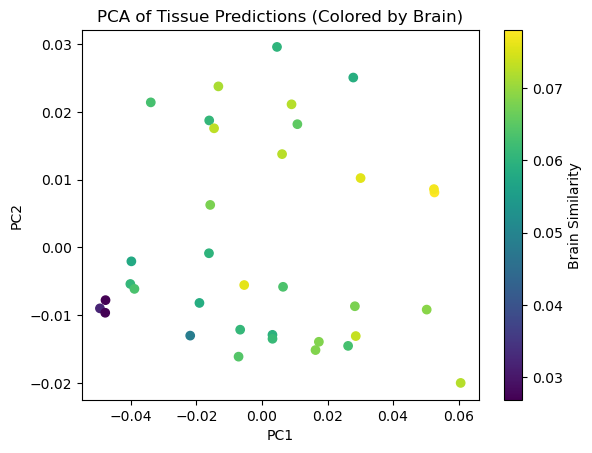

In [32]:
# Make a PCA and color the samples according to Brain similarity
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(prediction_df2.drop(columns=['sample']))
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_pca[['Brain']] = prediction_df2[['Brain']]
df_pca[['sample']] = prediction_df2[['sample']]

# Plot the reduced data with color according to 'Brain' column
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Brain'], cmap='viridis')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Brain Similarity')

# Add labels and title
plt.title('PCA of Tissue Predictions (Colored by Brain)')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Show the plot
plt.show()


Follow up analysis:   
Which proteins pop up more and more that make it more Retina like?

# 3. PFA dataset: why is this one so different?

1. There are less proteins which seem to be less tissue specific  (except for Esophagus and b-cells)   
Sample prep induced

In [34]:
protein_lists = []
for i in ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']:    
    df = pd.read_csv(i, sep='\t')
    proteins = np.array(df[["Protein.Ids"]].values.tolist()).flatten()
    # if it contains ';' split it and take both
    proteins = [x.split(';') for x in proteins]
    proteins = [item for sublist in proteins for item in sublist]
    proteins = list(set(proteins))
    print(i, len(proteins))
    protein_lists.append(set(proteins))

evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv 2764
proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv 3951
proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv 861


2764
3951
861


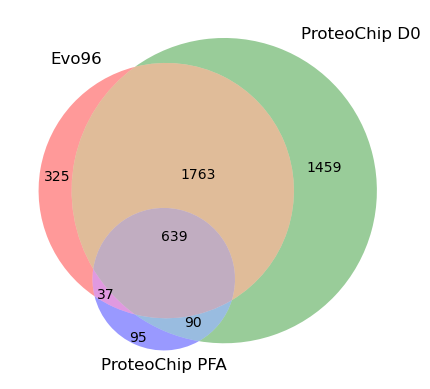

In [35]:
from matplotlib_venn import venn3
for i in protein_lists:
    print(len(i))
# Create the Venn diagram
venn3(protein_lists, ('Evo96', 'ProteoChip D0', 'ProteoChip PFA'))

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gprofiler import GProfiler

# Initialize g:Profiler
gp = GProfiler(return_dataframe=True)

# Dictionary to store GO terms and p-values for each tissue
go_dict = {}


# Perform GO enrichment analysis for each tissue and store p-values
for prots, name in zip(protein_lists, ['Evo96', 'ProteoChip D0', 'ProteoChip PFA']):
    results = gp.profile(organism='hsapiens', query=list(prots), sources=['GO:BP', 'GO:MF', 'GO:CC', 'HPA'])
    results = results[results['p_value']< 0.01]
    # Store results in the dictionary: {tissue: {GO_term: p-value}}
    go_dict[name] = dict(zip(results['name'], results['p_value']))

go_df = pd.DataFrame.from_dict(go_dict, orient='columns').fillna(0)
go_df.tail()



KeyboardInterrupt: 

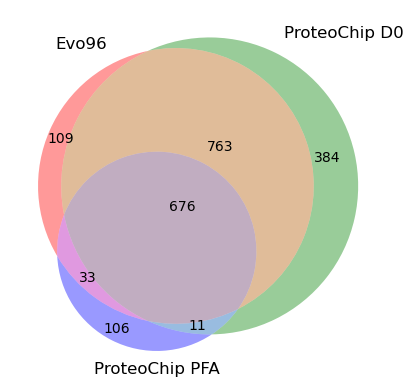

In [17]:
#make a venn diagram of go_dict terms
venn3([set(go_dict['Evo96'].keys()), set(go_dict['ProteoChip D0'].keys()), set(go_dict['ProteoChip PFA'].keys())], ('Evo96', 'ProteoChip D0', 'ProteoChip PFA'))

In [5]:
pfa = pd.read_csv("/home/compomics/git/MLMarker/Projects/organoids_pauline/peptides/pfa_report_organoides_042024_fixes.pr_matrix.tsv", sep='\t')
pfa_sequences = pfa['Stripped.Sequence'].values

ev096 = pd.read_csv("/home/compomics/git/MLMarker/Projects/organoids_pauline/peptides/evo96_report_organoids_culture_15042024_diann181.pr_matrix.tsv", sep='\t')
ev096_sequences = ev096['Stripped.Sequence'].values

d0 = pd.read_csv("/home/compomics/git/MLMarker/Projects/organoids_pauline/peptides/d0_report_organoids_culture_15042024_diann181.pr_matrix.tsv", sep='\t')
d0_sequences = d0['Stripped.Sequence'].values


In [6]:
len(pfa_sequences), len(ev096_sequences), len(d0_sequences)

(4172, 13636, 27870)

In [19]:
def calculate_hydrophobicity(sequence):
    """Calculate the average hydrophobicity of a sequence based on the amino acid composition and the hydrophobicity scale 
    from https://web.expasy.org/protscale/ GRAVY score sum of hydrophaty value of each residue/number of residues"""
    gravy_dict = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5, 'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5, 'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6, 'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}
    gravy = sum([gravy_dict[aa] for aa in sequence]) / len(sequence)
    return gravy
def calculate_molecular_weight(sequence):
    molweight_dict = {'A': 71.08, 'R': 156.19, 'N': 114.11, 'D': 115.09, 'C': 103.15, 'Q': 128.14, 'E': 129.12, 'G': 57.05, 'H': 137.14, 'I': 113.16, 'L': 113.16, 'K': 128.17, 'M': 131.19, 'F': 147.18, 'P': 97.12, 'S': 87.08, 'T': 101.11, 'W': 186.21, 'Y': 163.18, 'V': 99.13}
    molweight = sum([molweight_dict[aa] for aa in sequence])
    return molweight
def calculate_instability_index(sequence):
    instability_values = {
        'A': 1.0, 'R': -2.5, 'N': 0.9, 'D': -0.5, 'C': -1.0, 'Q': -1.2, 'E': -1.2, 'G': 0.3, 'H': -0.6,
        'I': -1.0, 'L': -1.2, 'K': 1.0, 'M': -1.2, 'F': -2.0, 'P': 0.7, 'S': 0.3, 'T': 0.2, 'W': -1.2, 'Y': -2.5, 'V': -1.2
    }
    instability_index = sum([instability_values[aa] for aa in sequence])
    return instability_index
def bulkiness(sequence):
    bulki_dict = {'A': 11.5, 'R': 14.28, 'N': 12.82, 'D': 11.68, 'C': 13.45, 'Q': 14.45, 'E': 13.57, 'G': 3.4, 'H': 13.69, 'I': 21.4, 'L': 21.4, 'K': 15.71, 'M': 16.25, 'F': 19.8, 'P': 17.43, 'S': 9.47, 'T': 15.77, 'W': 21.67, 'Y': 18.03, 'V': 21.57}

    
def calculate_isoelectric_point(sequence):
    pka_values = {'C-term': 3.1, 'N-term': 8.0, 'C': 8.5, 'D': 3.9, 'E': 4.1, 'H': 6.5, 'K': 10.8, 'R': 12.5, 'Y': 10.1}
    positive_residues = ['H', 'K', 'R', 'N-term']
    negative_residues = ['D', 'E', 'C', 'Y', 'C-term']
    # Binary search to find the pI where net charge is approximately 0
    pH_low, pH_high = 0, 14
    
    def net_charge_at_pH(pH):
            pos_charge = sum([10**pka_values[aa] / (10**pka_values[aa] + 10**pH) for aa in positive_residues if aa in sequence])
            neg_charge = sum([10**pH / (10**pka_values[aa] + 10**pH) for aa in negative_residues if aa in sequence])
            return pos_charge - neg_charge
            
    while pH_high - pH_low > 0.01:
        pH_mid = (pH_low + pH_high) / 2.0
        if net_charge_at_pH(pH_mid) > 0:
            pH_low = pH_mid
        else:
            pH_high = pH_mid
    return round((pH_low + pH_high) / 2.0, 2)

def calculate_charge(sequence, pH=2.5):
    positive_residues = {'K': 1, 'R': 1, 'H': 1}  # Lysine, Arginine, Histidine
    negative_residues = {'D': -1, 'E': -1}        # Aspartic acid, Glutamic acid
    
    # Start with N- and C-terminus contributions
    net_charge = 1  # N-terminus typically +1 at acidic pH
    c_terminus_charge = 0 if pH <= 3 else -1  # Neutral at pH <= 3, negative otherwise
    net_charge += c_terminus_charge
    
    # Add contributions from each residue
    for residue in sequence:
        if residue in positive_residues:
            net_charge += positive_residues[residue]
        elif residue in negative_residues:
            net_charge += negative_residues[residue]
    
    return net_charge

# Example usage



In [22]:
def plot_score(score_type, pfa_sequences, ev096_sequences, d0_sequences):
    if score_type == 'GRAVY':
        calculate_score = calculate_hydrophobicity
        title = 'GRAVY score'
    elif score_type == 'Molecular Weight':
        calculate_score = calculate_molecular_weight
        title = 'Molecular Weight'
    elif score_type == 'Instability Index':
        calculate_score = calculate_instability_index
        title = 'Instability Index'
    elif score_type == 'Isoelectric Point':
        calculate_score = calculate_isoelectric_point
        title = 'Isoelectric Point'
    elif score_type == 'Net charge':
        calculate_score = calculate_charge
        title = 'Net charge'
    else:
        raise ValueError('Invalid score type')
    pfa_score = []
    ev096_score = []
    d0_score = []
    for i in [pfa_sequences, ev096_sequences, d0_sequences]:
        for seq in i:
            score = calculate_score(seq)
            if len(i) == len(pfa_sequences):
                pfa_score.append(score)
            elif len(i) == len(ev096_sequences):
                ev096_score.append(score)
            else:
                d0_score.append(score)
    #boxplot of the three score distributions
    sns.boxplot(data=[pfa_score, ev096_score, d0_score])
    plt.xticks([0, 1, 2], ['PFA', 'Evo96', 'D0'])
    plt.ylabel(title)
    plt.title(title)
    plt.show()

PFA remaining proteins highly abundant <=> other sample preps   
C

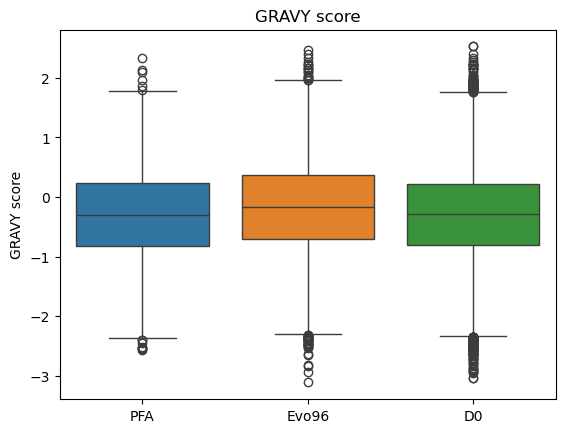

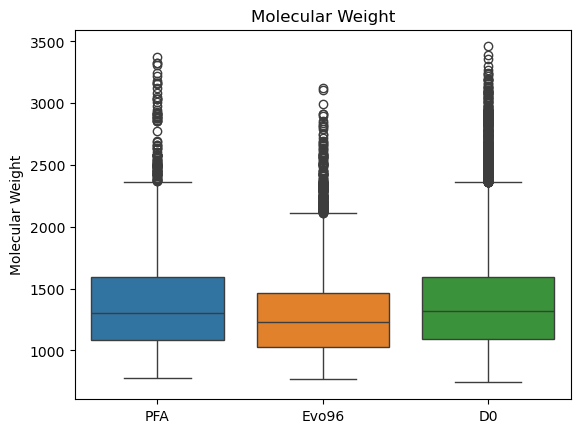

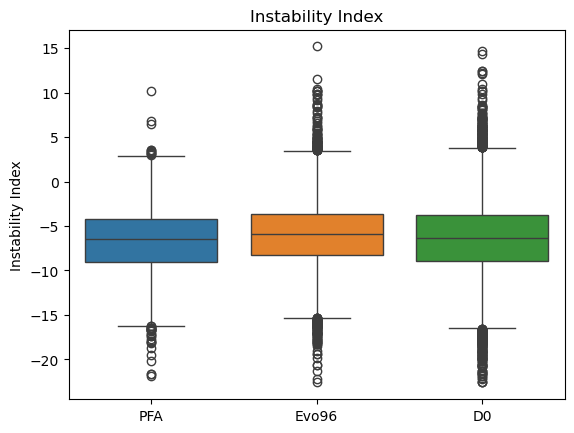

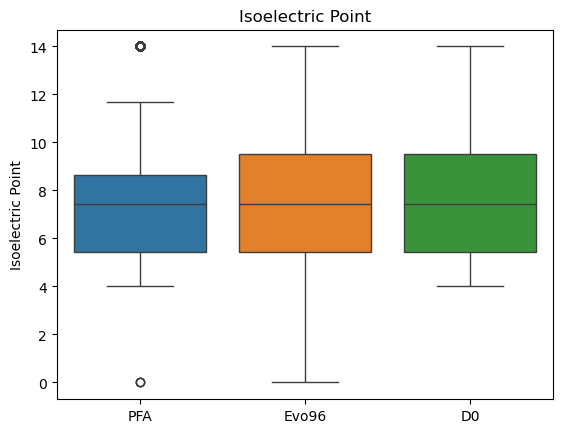

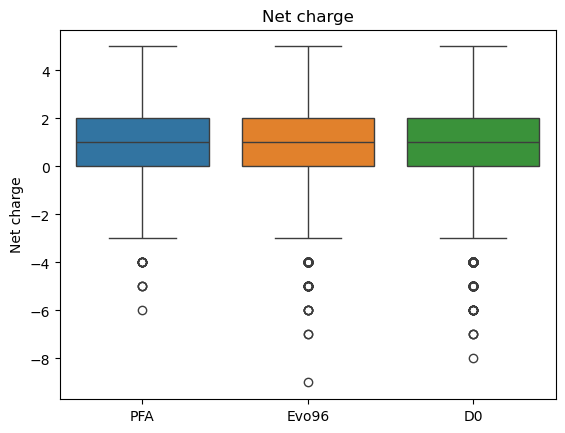

In [23]:
for i in ['GRAVY', 'Molecular Weight', 'Instability Index', 'Isoelectric Point', 'Net charge']:
    plot_score(i, pfa_sequences, ev096_sequences, d0_sequences)